# EasyVisa Project

## Context:

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

## Objective:

In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired your firm EasyVisa for data-driven solutions. You as a data scientist have to analyze the data provided and, with the help of a classification model:

* Facilitate the process of visa approvals.
* Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status. 


## Data Description

The data contains the different attributes of the employee and the employer. The detailed data dictionary is given below.

* case_id: ID of each visa application
* continent: Information of continent the employee
* education_of_employee: Information of education of the employee
* has_job_experience: Does the employee has any job experience? Y= Yes; N = No
* requires_job_training: Does the employee require any job training? Y = Yes; N = No 
* no_of_employees: Number of employees in the employer's company
* yr_of_estab: Year in which the employer's company was established
* region_of_employment: Information of foreign worker's intended region of employment in the US.
* prevailing_wage:  Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment. 
* unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
* full_time_position: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
* case_status:  Flag indicating if the Visa was certified or denied

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing necessary libraries and data

In [2]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier)

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import ( confusion_matrix, accuracy_score,precision_score, recall_score, f1_score)

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [3]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram



# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [4]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Python Course/EasyVisa.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


## Data Overview

- Observations
- Sanity checks

In [5]:
print('No of rows:',df.shape[0],'\n','No of cols:',df.shape[1],'\n')
print(' --------------------')
print('Data Information\n',df.info(),'\n')
print(' --------------------')
print('Data Description\n',df.describe().T,'\n')
print(' --------------------')
print('Number of Null Values\n',df.isnull().sum(),'\n')
print(' --------------------')
print('Number of duplicated values\n',df[df.duplicated()==True])




No of rows: 25480 
 No of cols: 12 

 --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB
Data Information
 None 

 ----------------

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'case_status']


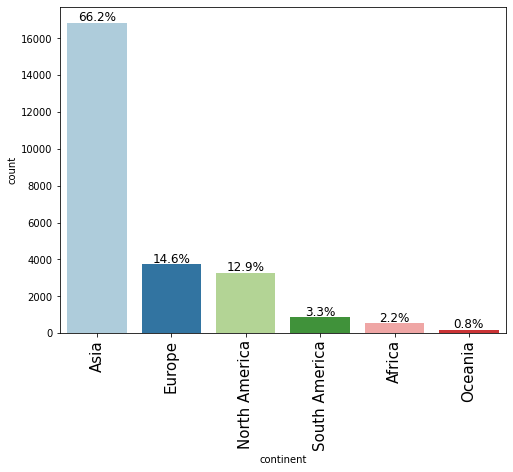

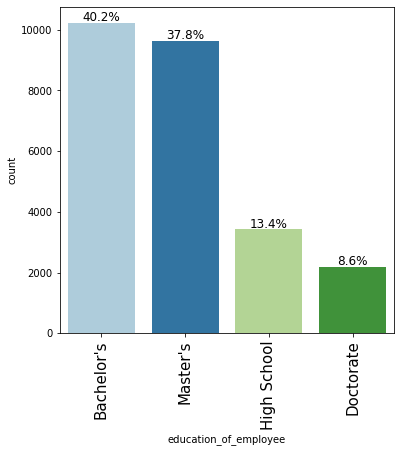

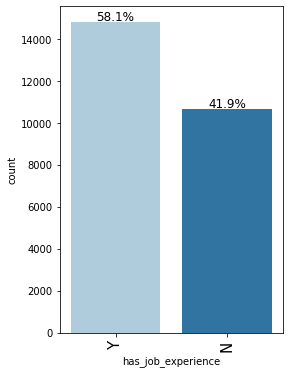

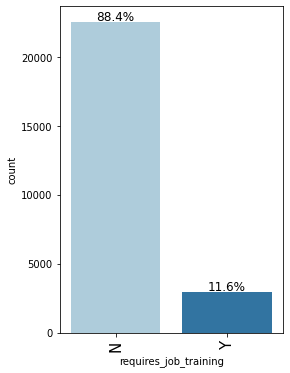

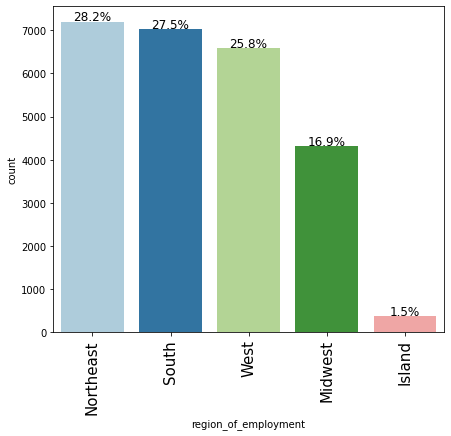

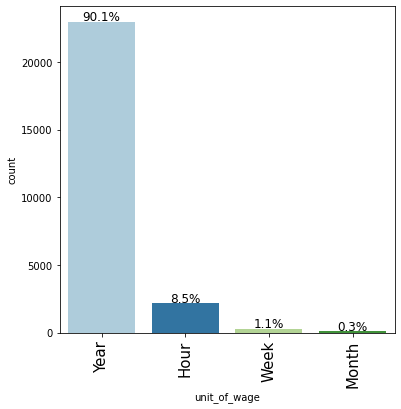

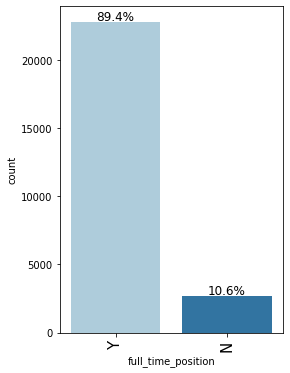

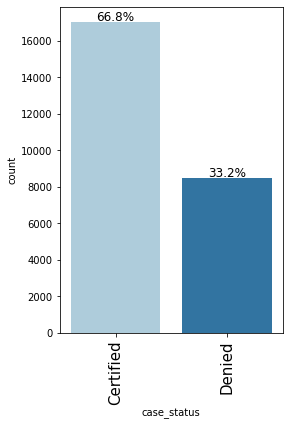

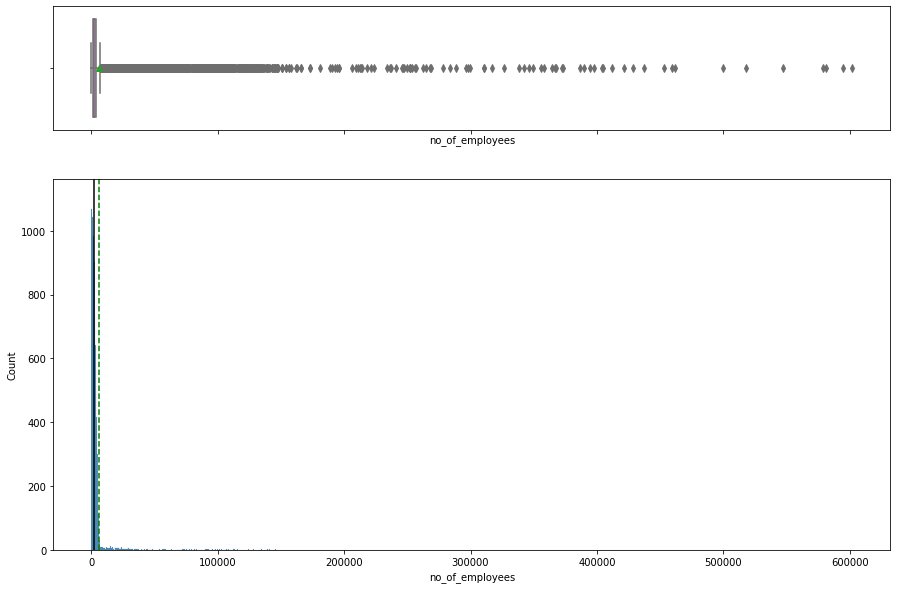

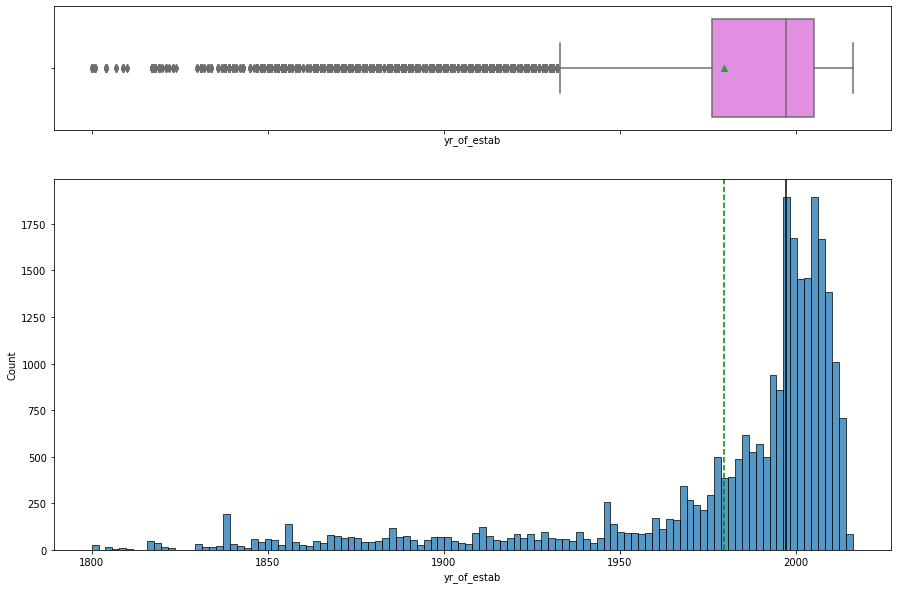

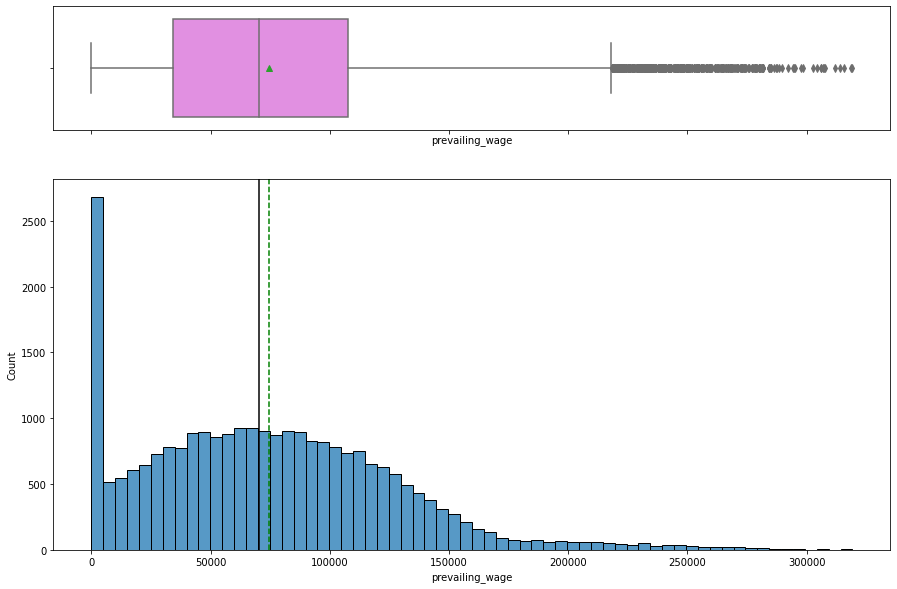

In [6]:
df2 = df.drop(["case_id"], axis=1)
obj_cols=list(df2.select_dtypes('object').columns)
print(obj_cols)
for ii in obj_cols:
  labeled_barplot(df, ii, perc=True)

df2['no_of_employees']=df2['no_of_employees'].abs()
cols_list = df2.select_dtypes(include=np.number).columns.tolist()
for ii in cols_list:
  histogram_boxplot(df2, ii)


**Leading Questions**:
1. Those with higher education may want to travel abroad for a well-paid job. Does education play a role in Visa certification? 

2. How does the visa status vary across different continents? 
 
3. Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Does work experience influence visa status? 
 
4. In the United States, employees are paid at different intervals. Which pay unit is most likely to be certified for a visa? 
 
5. The US government has established a prevailing wage to protect local talent and foreign workers. How does the visa status change with the prevailing wage?

case_status            Certified  Denied    All
education_of_employee                          
All                        17018    8462  25480
Bachelor's                  6367    3867  10234
High School                 1164    2256   3420
Master's                    7575    2059   9634
Doctorate                   1912     280   2192
------------------------------------------------------------------------------------------------------------------------


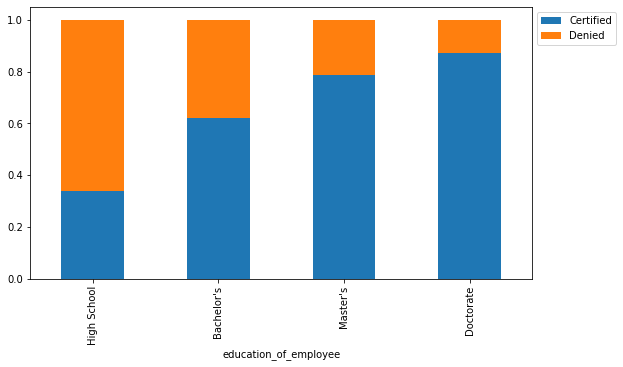

case_status    Certified  Denied    All
continent                              
All                17018    8462  25480
Asia               11012    5849  16861
North America       2037    1255   3292
Europe              2957     775   3732
South America        493     359    852
Africa               397     154    551
Oceania              122      70    192
------------------------------------------------------------------------------------------------------------------------


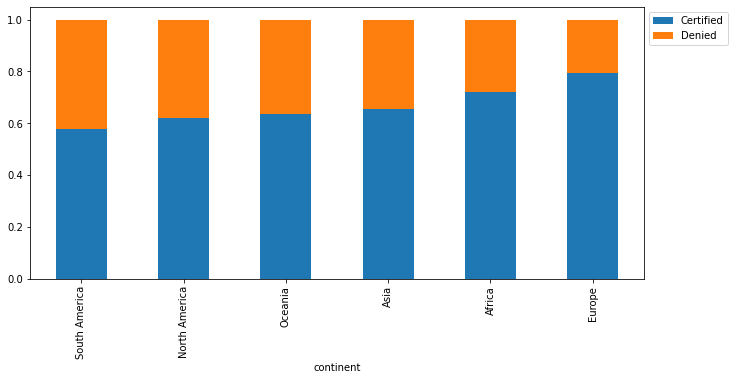

case_status         Certified  Denied    All
has_job_experience                          
All                     17018    8462  25480
N                        5994    4684  10678
Y                       11024    3778  14802
------------------------------------------------------------------------------------------------------------------------


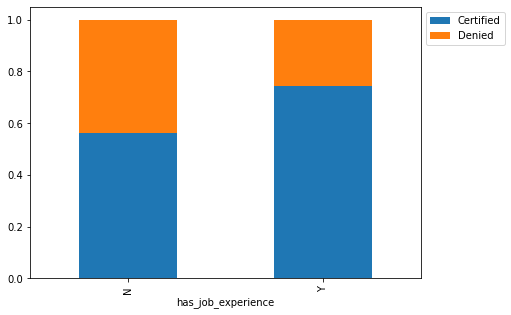

case_status   Certified  Denied    All
unit_of_wage                          
All               17018    8462  25480
Year              16047    6915  22962
Hour                747    1410   2157
Week                169     103    272
Month                55      34     89
------------------------------------------------------------------------------------------------------------------------


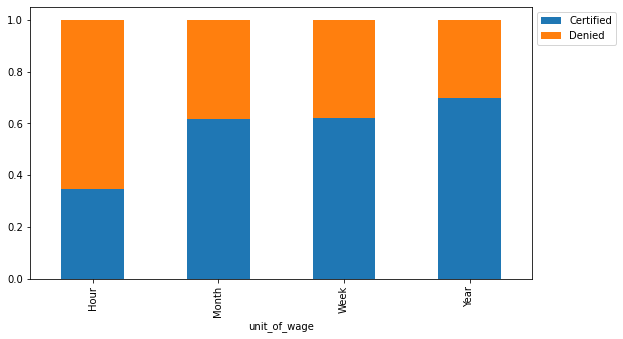

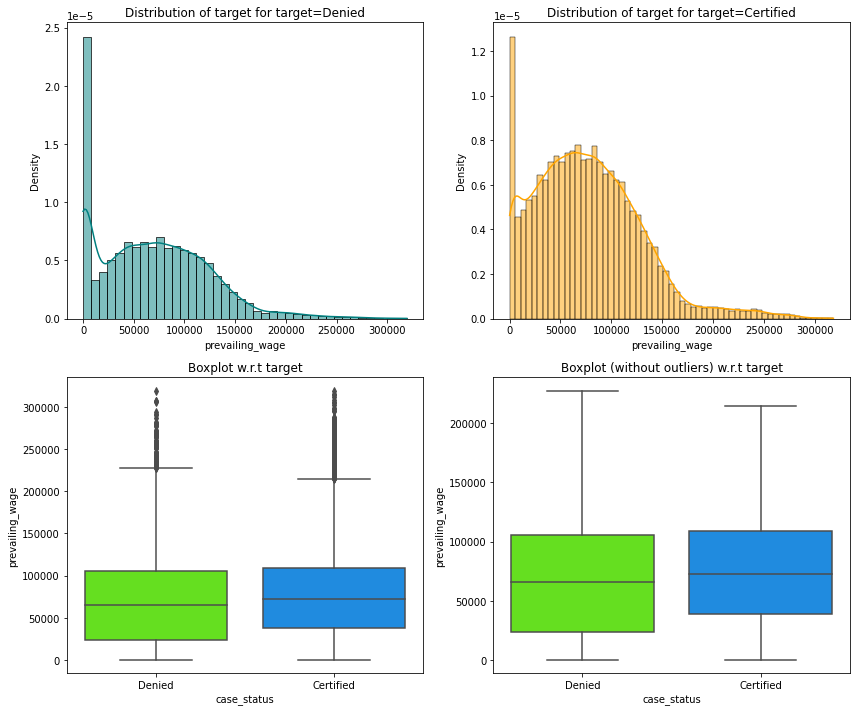

In [7]:
# 1. Those with higher education may want to travel abroad for a well-paid job. Does education play a role in Visa certification? 
stacked_barplot(df2,'education_of_employee', 'case_status')
# 2. How does the visa status vary across different continents? 
stacked_barplot(df2, 'continent', 'case_status') 
# 3. Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Does work experience influence visa status? 
stacked_barplot(df2, 'has_job_experience', 'case_status')  
# 4. In the United States, employees are paid at different intervals. Which pay unit is most likely to be certified for a visa? 
stacked_barplot(df2, 'unit_of_wage', 'case_status')  
# 5. The US government has established a prevailing wage to protect local talent and foreign workers. How does the visa status change with the prevailing wage?
distribution_plot_wrt_target(df2, 'prevailing_wage', 'case_status')

## Data Preprocessing

- Missing value treatment (if needed)
- Feature engineering 
- Outlier detection and treatment (if needed)
- Preparing data for modeling 
- Any other preprocessing steps (if needed)

In [8]:
df2["case_status"] = df2["case_status"].apply(lambda x: 1 if x == "Certified" else 0)

X = df2.drop(['case_status'],axis=1)
Y = df2["case_status"]

X = pd.get_dummies(X,drop_first=True) 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)


Shape of Training set :  (17836, 21)
Shape of test set :  (7644, 21)


## Building bagging and boosting models

In [9]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


    

###**Decision Tree Model**

peformance on training data

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0 

peformance on test data

   Accuracy    Recall  Precision        F1
0  0.664835  0.742801   0.752232  0.747487 



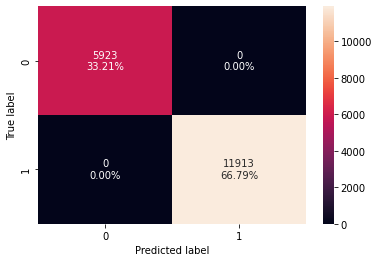

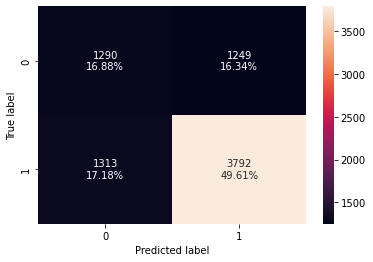

In [10]:
model0 = DecisionTreeClassifier(random_state=1)
model0.fit(X_train, Y_train)
# Checking model performance on training set
confusion_matrix_sklearn(model0, X_train, Y_train)
decision_tree_perf_train = model_performance_classification_sklearn(model0, X_train, Y_train) 
print('peformance on training data\n')
print(decision_tree_perf_train,'\n')
# Checking model performance on test set
confusion_matrix_sklearn(model0,X_test,Y_test) 
decision_tree_perf_test = model_performance_classification_sklearn(model0,X_test,Y_test) ## Complete the code to check performance for test data
print('peformance on test data\n')
print(decision_tree_perf_test,'\n')

peformance on training data

   Accuracy    Recall  Precision        F1
0  0.729816  0.910602   0.742912  0.818254 

peformance on training data

   Accuracy    Recall  Precision        F1
0  0.722397  0.910088   0.736408  0.814088 



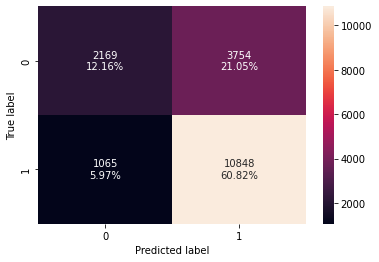

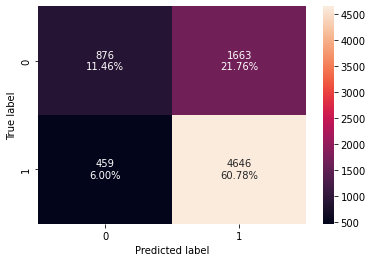

In [11]:
# Hyperparameter Tuning - Decision Tree
dtree_estimator = DecisionTreeClassifier(class_weight="balanced", random_state=1)

parameters = {
    "max_depth": np.arange(5, 16, 5),
    "min_samples_leaf": [3, 5, 7],
    "max_leaf_nodes": [2, 5],
    "min_impurity_decrease": [0.0001, 0.001],
}

scorer = metrics.make_scorer(metrics.f1_score)
grid_obj = GridSearchCV(model0, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(X_train, Y_train)
dtree_estimator = grid_obj.best_estimator_

dtree_estimator.fit(X_train, Y_train)
confusion_matrix_sklearn(dtree_estimator,X_train,Y_train) 
dtree_estimator_model_train_perf = model_performance_classification_sklearn(dtree_estimator,X_train,Y_train) 
print('peformance on training data\n')
print(dtree_estimator_model_train_perf,'\n')
confusion_matrix_sklearn(dtree_estimator,X_test,Y_test) 
dtree_estimator_model_test_perf = model_performance_classification_sklearn(dtree_estimator,X_test,Y_test) 
print('peformance on training data\n')
print(dtree_estimator_model_test_perf,'\n')



Training performance:
    Accuracy    Recall  Precision        F1
0  0.985198  0.985982    0.99181  0.988887
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.691523  0.764153   0.771711  0.767913


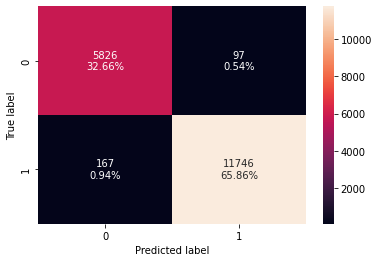

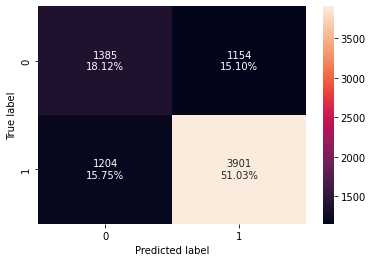

In [12]:
# Bagging Classifier
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,Y_train)

confusion_matrix_sklearn(bagging_classifier, X_train, Y_train)
bagging_classifier_model_train_perf=model_performance_classification_sklearn(bagging_classifier,X_train,Y_train)
print("Training performance:\n",bagging_classifier_model_train_perf)
bagging_classifier_model_test_perf=model_performance_classification_sklearn(bagging_classifier,X_test,Y_test)
print("Testing performance:\n",bagging_classifier_model_test_perf)
confusion_matrix_sklearn(bagging_classifier, X_test, Y_test)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.996187  0.999916   0.994407  0.997154
Test performance:
    Accuracy    Recall  Precision        F1
0  0.996187  0.999916   0.994407  0.997154


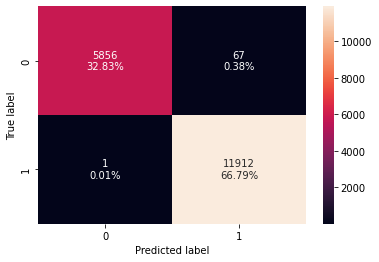

In [13]:

# Hyperparameter Tuning - Bagging Classifier
bagging_estimator_tuned = BaggingClassifier(random_state=1)

parameters = {
    "max_samples": [0.7, 0.9],
    "max_features": [0.7, 0.9],
    "n_estimators": np.arange(90, 111, 10),
}

acc_scorer = metrics.make_scorer(metrics.f1_score)

grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, Y_train)

bagging_estimator_tuned = grid_obj.best_estimator_

bagging_estimator_tuned.fit(X_train, Y_train)
confusion_matrix_sklearn(bagging_estimator_tuned, X_train, Y_train)
bagging_estimator_tuned_model_train_perf = model_performance_classification_sklearn(bagging_estimator_tuned, X_train, Y_train) 
print("Training performance:\n",bagging_estimator_tuned_model_train_perf)
bagging_estimator_tuned_model_test_perf = model_performance_classification_sklearn(bagging_estimator_tuned, X_train, Y_train) 
print("Test performance:\n",bagging_estimator_tuned_model_test_perf)




Training performance:
    Accuracy    Recall  Precision        F1
0  0.999944  0.999916        1.0  0.999958
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.720827  0.832125   0.768869  0.799247
Training performance:
    Accuracy   Recall  Precision        F1
0  0.769119  0.91866   0.776556  0.841652
Testing performance:
    Accuracy    Recall  Precision       F1
0  0.738095  0.898923   0.755391  0.82093


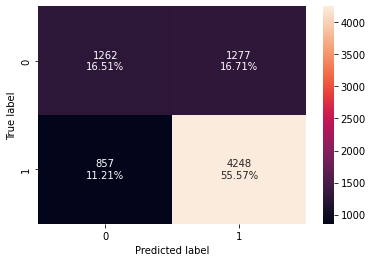

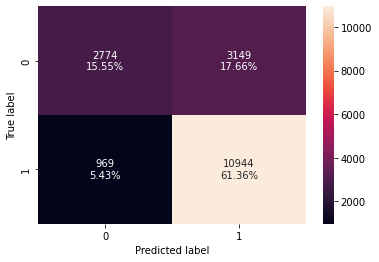

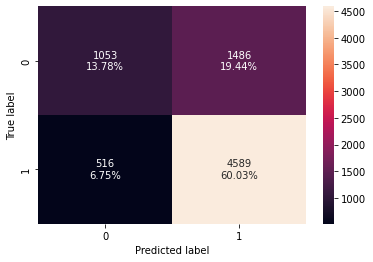

In [14]:
# Random Forest
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,Y_train)

rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator,X_train,Y_train)
print("Training performance:\n",rf_estimator_model_train_perf)
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator,X_test,Y_test)
print("Testing performance:\n",rf_estimator_model_test_perf)
confusion_matrix_sklearn(rf_estimator, X_test, Y_test)

# Hyperparameter Tuning - Random Forest
rf_tuned = RandomForestClassifier(random_state=1, oob_score=True, bootstrap=True)

parameters = {
    "max_depth": list(np.arange(5, 15, 5)),
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [5, 7],
    "n_estimators": np.arange(15, 26, 5),
}

acc_scorer = metrics.make_scorer(metrics.f1_score)

grid_obj = GridSearchCV(rf_tuned, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, Y_train)

rf_tuned = grid_obj.best_estimator_

rf_tuned.fit(X_train, Y_train)
confusion_matrix_sklearn(rf_tuned, X_train, Y_train)
rf_tuned_model_train_perf = model_performance_classification_sklearn(rf_tuned, X_train, Y_train) 
print("Training performance:\n",rf_tuned_model_train_perf)
confusion_matrix_sklearn(rf_tuned, X_test, Y_test)
rf_tuned_model_test_perf = model_performance_classification_sklearn(rf_tuned, X_test, Y_test) ## Complete the code to check performance for test data on tuned estimator
print("Testing performance:\n",rf_tuned_model_test_perf)




Training performance:
    Accuracy    Recall  Precision       F1
0  0.738226  0.887182   0.760688  0.81908
Testing performance:
    Accuracy    Recall  Precision       F1
0  0.738095  0.898923   0.755391  0.82093
Training performance:
    Accuracy    Recall  Precision        F1
0  0.718995  0.781247   0.794587  0.787861
Testing performance:
    Accuracy    Recall  Precision        F1
0   0.71651  0.781391   0.791468  0.786397


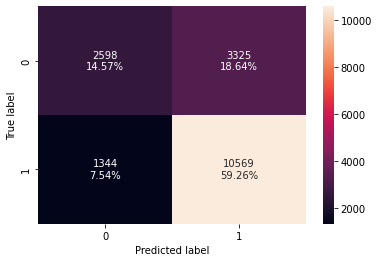

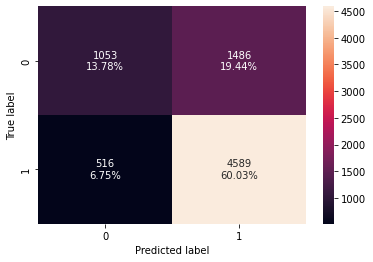

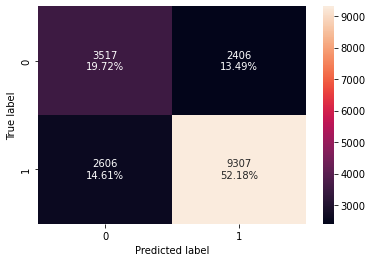

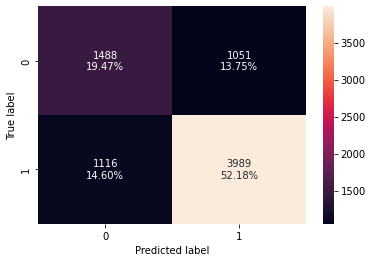

In [15]:
# AdaBoost Classifier
ab_classifier = AdaBoostClassifier(random_state=1) 
ab_classifier.fit(X_train,Y_train) 

confusion_matrix_sklearn(ab_classifier, X_train, Y_train)
ab_classifier_model_train_perf = model_performance_classification_sklearn(ab_classifier, X_train, Y_train) 
print("Training performance:\n",ab_classifier_model_train_perf)
confusion_matrix_sklearn(rf_tuned, X_test, Y_test)
ab_classifier_model_test_perf = model_performance_classification_sklearn(rf_tuned, X_test, Y_test) 
print("Testing performance:\n",ab_classifier_model_test_perf)

#Tuning
abc_tuned = AdaBoostClassifier(random_state=1)
parameters = {
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, class_weight="balanced", random_state=1),
        DecisionTreeClassifier(max_depth=2, class_weight="balanced", random_state=1),
    ],
    "n_estimators": np.arange(80, 101, 10),
    "learning_rate": np.arange(0.1, 0.4, 0.1),
}

acc_scorer = metrics.make_scorer(metrics.f1_score)

grid_obj = GridSearchCV(abc_tuned, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, Y_train)

abc_tuned = grid_obj.best_estimator_

abc_tuned.fit(X_train, Y_train)
confusion_matrix_sklearn(abc_tuned, X_train, Y_train)
abc_tuned_model_train_perf = model_performance_classification_sklearn(abc_tuned, X_train, Y_train) ## Complete the code to check performance for train data on tuned estimator
print("Training performance:\n",abc_tuned_model_train_perf)
confusion_matrix_sklearn(abc_tuned, X_test, Y_test)
abc_tuned_model_test_perf = model_performance_classification_sklearn(abc_tuned, X_test, Y_test) ## Complete the code to check performance for test data on tuned estimator
print("Testing performance:\n",abc_tuned_model_test_perf)


Training performance:
    Accuracy   Recall  Precision        F1
0  0.758802  0.88374   0.783042  0.830349
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.744767  0.876004   0.772366  0.820927
Training performance:
    Accuracy    Recall  Precision        F1
0  0.764017  0.882649   0.789059  0.833234
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.743459  0.871303   0.773296  0.819379


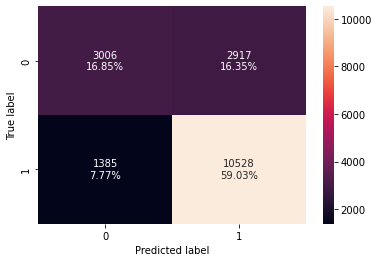

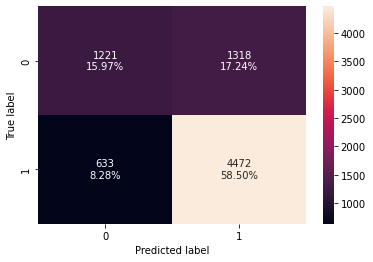

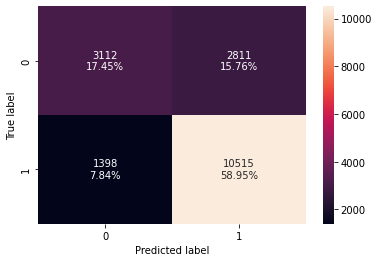

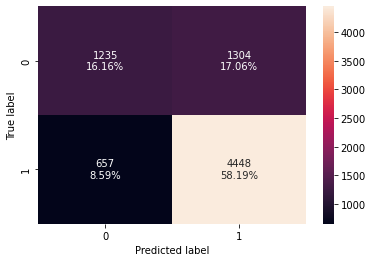

In [16]:
# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,Y_train) 
confusion_matrix_sklearn(gb_classifier, X_train, Y_train)
gb_classifier_model_train_perf = model_performance_classification_sklearn(gb_classifier, X_train, Y_train)
print("Training performance:\n",gb_classifier_model_train_perf)
confusion_matrix_sklearn(gb_classifier, X_test, Y_test)
gb_classifier_model_test_perf = model_performance_classification_sklearn(gb_classifier, X_test, Y_test)
print("Testing performance:\n",gb_classifier_model_test_perf)

# Hyperparameter Tuning 
gbc_tuned = GradientBoostingClassifier(
    init=AdaBoostClassifier(random_state=1), random_state=1
)

parameters = {
    "n_estimators": [200, 250],
    "subsample": [0.9, 1],
    "max_features": [0.8, 0.9],
    "learning_rate": np.arange(0.1, 0.21, 0.1),
}

acc_scorer = metrics.make_scorer(metrics.f1_score)

grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, Y_train)

gbc_tuned = grid_obj.best_estimator_
gbc_tuned.fit(X_train, Y_train)
confusion_matrix_sklearn(gbc_tuned, X_train, Y_train)
gbc_tuned_model_train_perf = model_performance_classification_sklearn(gbc_tuned, X_train, Y_train) 
print("Training performance:\n",gbc_tuned_model_train_perf)
confusion_matrix_sklearn(gbc_tuned, X_test, Y_test)
gbc_tuned_model_test_perf = model_performance_classification_sklearn(gbc_tuned, X_test, Y_test) 
print("Testing performance:\n",gbc_tuned_model_test_perf)



Training performance:
    Accuracy    Recall  Precision        F1
0  0.756279  0.883573   0.780513  0.828852
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.744636  0.877375   0.771576  0.821082
Training performance:
    Accuracy    Recall  Precision        F1
0  0.756504  0.883069   0.780995  0.828901
Testing performance:
    Accuracy  Recall  Precision        F1
0  0.744244  0.8762   0.771739  0.820659


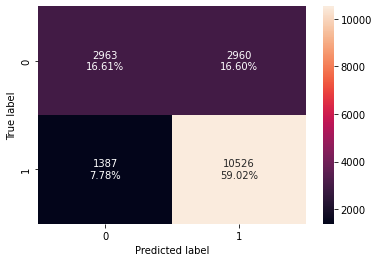

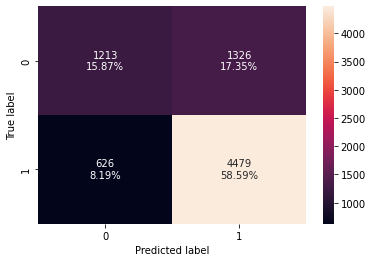

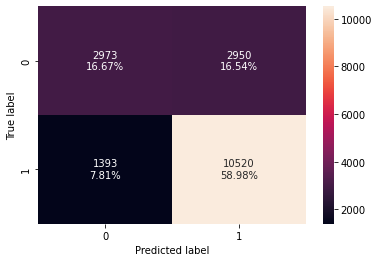

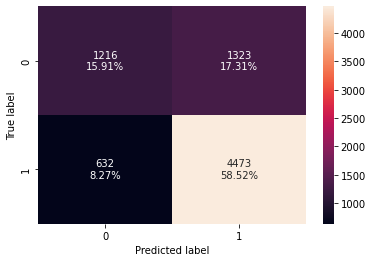

In [17]:

# XGBoost Classifier
xgb_classifier =XGBClassifier(random_state=1, verbosity = 0)
xgb_classifier.fit(X_train,Y_train)

confusion_matrix_sklearn(xgb_classifier, X_train, Y_train)
xgb_classifier_model_train_perf = model_performance_classification_sklearn(xgb_classifier, X_train, Y_train) 
print("Training performance:\n",xgb_classifier_model_train_perf)
confusion_matrix_sklearn(xgb_classifier, X_test, Y_test)
xgb_classifier_model_test_perf = model_performance_classification_sklearn(xgb_classifier, X_test, Y_test) 
print("Testing performance:\n",xgb_classifier_model_test_perf)

# Hyperparameter Tuning - XGBoost Classifier
xgb_tuned = XGBClassifier(random_state=1, eval_metric="logloss")

parameters = {
    "n_estimators": np.arange(150, 250, 50),
    "scale_pos_weight": [1, 2],
    "subsample": [0.9, 1],
    "learning_rate": np.arange(0.1, 0.21, 0.1),
    "gamma": [3, 5],
    "colsample_bytree": [0.8, 0.9],
    "colsample_bylevel": [ 0.9, 1],
}

acc_scorer = metrics.make_scorer(metrics.f1_score)

grid_obj = GridSearchCV(xgb_tuned, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, Y_train)
xgb_tuned = grid_obj.best_estimator_

xgb_tuned.fit(X_train, Y_train)
confusion_matrix_sklearn(xgb_tuned, X_train, Y_train)
xgb_tuned_model_train_perf = model_performance_classification_sklearn(xgb_tuned, X_train, Y_train) ## Complete the code to check performance for train data on tuned estimator
print("Training performance:\n",xgb_tuned_model_train_perf)
confusion_matrix_sklearn(xgb_tuned, X_test, Y_test)
xgb_tuned_model_test_perf = model_performance_classification_sklearn(xgb_tuned, X_test, Y_test) ## Complete the code to check performance for test data on tuned estimator
print("Testing performance:\n",xgb_tuned_model_test_perf)



Training performance:
    Accuracy    Recall  Precision        F1
0  0.767549  0.891211   0.788372  0.836643
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.744898  0.878355   0.771375  0.821396


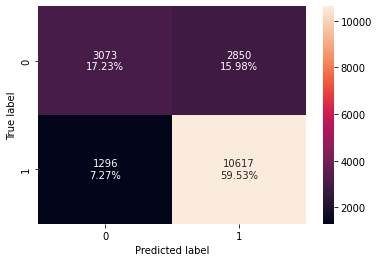

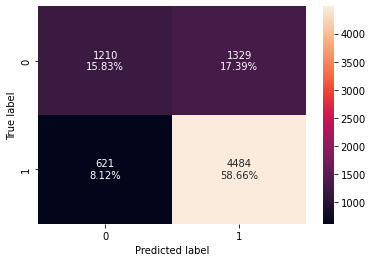

In [18]:
# Stacking Classifier
estimators = [
    ("AdaBoost", ab_classifier),
    ("Gradient Boosting", gbc_tuned),
    ("Random Forest", rf_tuned),
]

final_estimator = xgb_tuned

stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=final_estimator,cv=5)
stacking_classifier.fit(X_train,Y_train)
confusion_matrix_sklearn(stacking_classifier, X_train, Y_train)
stacking_classifier_model_train_perf = model_performance_classification_sklearn(stacking_classifier, X_train, Y_train)
print("Training performance:\n",stacking_classifier_model_train_perf)
confusion_matrix_sklearn(stacking_classifier, X_test, Y_test)
stacking_classifier_model_test_perf = model_performance_classification_sklearn(stacking_classifier, X_test, Y_test) 
print("Testing performance:\n",stacking_classifier_model_test_perf)


In [19]:


models_train_comp_df = pd.concat(
    [
        decision_tree_perf_train.T,
        dtree_estimator_model_train_perf.T,
        bagging_classifier_model_train_perf.T,
        bagging_estimator_tuned_model_train_perf.T,
        rf_estimator_model_train_perf.T,
        rf_tuned_model_train_perf.T,
        ab_classifier_model_train_perf.T,
        abc_tuned_model_train_perf.T,
        gb_classifier_model_train_perf.T,
        gbc_tuned_model_train_perf.T,
        xgb_classifier_model_train_perf.T,
        xgb_tuned_model_train_perf.T,
        stacking_classifier_model_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Tuned Decision Tree",
    "Bagging Classifier",
    "Tuned Bagging Classifier",
    "Random Forest",
    "Tuned Random Forest",
    "Adaboost Classifier",
    "Tuned Adaboost Classifier",
    "Gradient Boost Classifier",
    "Tuned Gradient Boost Classifier",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier",
]
print("Training performance comparison:")
models_train_comp_df


# testing performance comparison


models_test_comp_df = pd.concat(
    [
        decision_tree_perf_test.T,
        dtree_estimator_model_test_perf.T,
        bagging_classifier_model_test_perf.T,
        bagging_estimator_tuned_model_test_perf.T,
        rf_estimator_model_test_perf.T,
        rf_tuned_model_test_perf.T,
        ab_classifier_model_test_perf.T,
        abc_tuned_model_test_perf.T,
        gb_classifier_model_test_perf.T,
        gbc_tuned_model_test_perf.T,
        xgb_classifier_model_test_perf.T,
        xgb_tuned_model_test_perf.T,
        stacking_classifier_model_test_perf.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree",
    "Tuned Decision Tree",
    "Bagging Classifier",
    "Tuned Bagging Classifier",
    "Random Forest",
    "Tuned Random Forest",
    "Adaboost Classifier",
    "Tuned Adaboost Classifier",
    "Gradient Boost Classifier",
    "Tuned Gradient Boost Classifier",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier",
]
print("Testing performance comparison:")
models_test_comp_df



Training performance comparison:
Testing performance comparison:


,Decision Tree,Tuned Decision Tree,Bagging Classifier,Tuned Bagging Classifier,Random Forest,Tuned Random Forest,Adaboost Classifier,Tuned Adaboost Classifier,Gradient Boost Classifier,Tuned Gradient Boost Classifier,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,0.664835,0.722397,0.691523,0.996187,0.720827,0.738095,0.738095,0.716510,0.744767,0.743459,0.744636,0.744244,0.744898
Recall,0.742801,0.910088,0.764153,0.999916,0.832125,0.898923,0.898923,0.781391,0.876004,0.871303,0.877375,0.876200,0.878355
Precision,0.752232,0.736408,0.771711,0.994407,0.768869,0.755391,0.755391,0.791468,0.772366,0.773296,0.771576,0.771739,0.771375
F1,0.747487,0.814088,0.767913,0.997154,0.799247,0.820930,0.820930,0.786397,0.820927,0.819379,0.821082,0.820659,0.821396


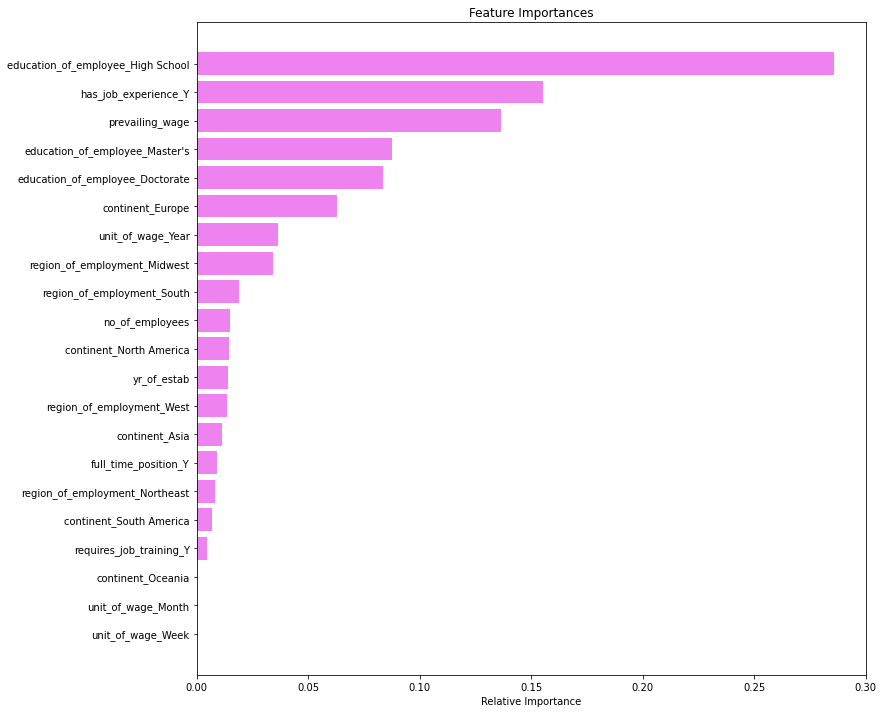

In [20]:

# Important features of the final model
feature_names = X_train.columns
importances = gb_classifier.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()


## Actionable Insights and Recommendations

###### Education of the employee and the previous job experience are the dominant factor for visa application

In [ ]:
%%shell
jupyter nbconvert --to html /content/DSBA_Project_ET_EasyVisa_Fullcode.ipynb
